## K-Means Clustering

**Overview**<br>
<a href="https://archive.ics.uci.edu/ml/datasets/online+retail">Online retail is a transnational data set</a> which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

The steps are broadly:
1. Read and understand the data
2. Clean the data
3. Prepare the data for modelling
4. Modelling
5. Final analysis and reco

# 1. Read and visualise the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [7]:
# read the dataset
retail_df = pd.read_csv("Cricket.csv", sep=",", encoding="ISO-8859-1", header=0)
retail_df.head()

,Player,Span,Mat,Inns,NO,Runs,HS,Ave,BF,SR,100,50,0
0,SR Tendulkar (INDIA),1989-2012,463,452,41,18426,200*,44.83,21367,86.23,49,96,20
1,KC Sangakkara (Asia/ICC/SL),2000-2015,404,380,41,14234,169,41.98,18048,78.86,25,93,15
2,RT Ponting (AUS/ICC),1995-2012,375,365,39,13704,164,42.03,17046,80.39,30,82,20
3,ST Jayasuriya (Asia/SL),1989-2011,445,433,18,13430,189,32.36,14725,91.20,28,68,34
4,DPMD Jayawardene (Asia/SL),1998-2015,448,418,39,12650,144,33.37,16020,78.96,19,77,28


In [8]:
# basics of the df
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79 entries, 0 to 78
Data columns (total 13 columns):
Player    79 non-null object
Span      79 non-null object
Mat       79 non-null int64
Inns      79 non-null int64
NO        79 non-null int64
Runs      79 non-null int64
HS        79 non-null object
Ave       79 non-null float64
BF        79 non-null int64
SR        79 non-null float64
100       79 non-null int64
50        79 non-null int64
0         79 non-null int64
dtypes: float64(2), int64(8), object(3)
memory usage: 8.1+ KB


# 2. Clean the data

In [4]:
# missing values
round(100*(retail_df.isnull().sum())/len(retail_df), 2)

Player    0.0
Span      0.0
Mat       0.0
Inns      0.0
NO        0.0
Runs      0.0
HS        0.0
Ave       0.0
BF        0.0
SR        0.0
100       0.0
50        0.0
0         0.0
dtype: float64

In [5]:
# drop all rows having missing values
retail_df = retail_df.dropna()
retail_df.shape

(79, 13)

In [9]:
retail_df.head()

,Player,Span,Mat,Inns,NO,Runs,HS,Ave,BF,SR,100,50,0
0,SR Tendulkar (INDIA),1989-2012,463,452,41,18426,200*,44.83,21367,86.23,49,96,20
1,KC Sangakkara (Asia/ICC/SL),2000-2015,404,380,41,14234,169,41.98,18048,78.86,25,93,15
2,RT Ponting (AUS/ICC),1995-2012,375,365,39,13704,164,42.03,17046,80.39,30,82,20
3,ST Jayasuriya (Asia/SL),1989-2011,445,433,18,13430,189,32.36,14725,91.20,28,68,34
4,DPMD Jayawardene (Asia/SL),1998-2015,448,418,39,12650,144,33.37,16020,78.96,19,77,28


# 3. Prepare the data for modelling

- R (Recency): Number of days since last purchase
- F (Frequency): Number of tracsactions
- M (Monetary): Total amount of transactions (revenue contributed)

In [13]:
# Strike-Rate
sr_df = retail_df[['Player', 'SR']]
sr_df.head()

,Player,SR
0,SR Tendulkar (INDIA),86.23
1,KC Sangakkara (Asia/ICC/SL),78.86
2,RT Ponting (AUS/ICC),80.39
3,ST Jayasuriya (Asia/SL),91.20
4,DPMD Jayawardene (Asia/SL),78.96


In [14]:
# Average
av_df = retail_df[['Player', 'Ave']]
av_df.head()

,Player,Ave
0,SR Tendulkar (INDIA),44.83
1,KC Sangakkara (Asia/ICC/SL),41.98
2,RT Ponting (AUS/ICC),42.03
3,ST Jayasuriya (Asia/SL),32.36
4,DPMD Jayawardene (Asia/SL),33.37


In [15]:
# merge the two dfs
df = pd.merge(sr_df, av_df, on='Player', how='inner')
df.head()

,Player,SR,Ave
0,SR Tendulkar (INDIA),86.23,44.83
1,KC Sangakkara (Asia/ICC/SL),78.86,41.98
2,RT Ponting (AUS/ICC),80.39,42.03
3,ST Jayasuriya (Asia/SL),91.20,32.36
4,DPMD Jayawardene (Asia/SL),78.96,33.37


{'whiskers': [<matplotlib.lines.Line2D at 0x192f325e518>,
 'caps': [<matplotlib.lines.Line2D at 0x192f325eba8>,
 'boxes': [<matplotlib.lines.Line2D at 0x192f325e0f0>],
 'medians': [<matplotlib.lines.Line2D at 0x192f325efd0>],
 'fliers': [<matplotlib.lines.Line2D at 0x192f32685c0>],
 'means': []}

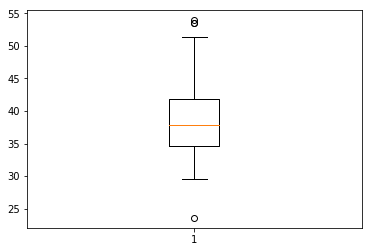

In [17]:
# 1. outlier treatment
plt.boxplot(df['Ave'])

In [18]:
# 2. rescaling
rfm_df = df[['Ave', 'SR']]

# instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(79, 2)

In [19]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Ave', 'SR']
rfm_df_scaled.head()

,Ave,SR
0,1.072294,0.703152
1,0.587725,-0.044139
2,0.596226,0.110997
3,-1.047909,1.207091
4,-0.876185,-0.034000


# 4. Modelling

In [21]:
# k-means with some arbitrary k
kmeans = KMeans(n_clusters=4, max_iter=50, random_state=100)
kmeans.fit(rfm_df_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
    n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=100, tol=0.0001, verbose=0)

In [22]:
kmeans.labels_

array([3, 1, 1, 0, 2, 1, 1, 1, 1, 1, 0, 1, 0, 3, 2, 3, 2, 0, 1, 1, 0, 1,
       2, 1, 0, 3, 2, 0, 2, 1, 2, 2, 1, 2, 3, 2, 2, 1, 3, 1, 2, 2, 3, 2,
       2, 2, 1, 2, 2, 1, 0, 1, 2, 2, 2, 2, 1, 0, 2, 0, 2, 0, 1, 3, 3, 1,
       1, 2, 1, 2, 1, 2, 2, 2, 1, 1, 2, 0, 2])

In [23]:
# help(KMeans)

## Finding the Optimal Number of Clusters

### SSD

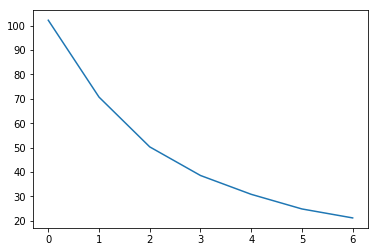

In [24]:
# elbow-curve/SSD
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
# ssd
plt.plot(ssd)

### Silhouette Analysis

$$\text{silhouette score}=\frac{p-q}{max(p,q)}$$

$p$ is the mean distance to the points in the nearest cluster that the data point is not a part of

$q$ is the mean intra-cluster distance to all the points in its own cluster.

* The value of the silhouette score range lies between -1 to 1. 

* A score closer to 1 indicates that the data point is very similar to other data points in the cluster, 

* A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

In [25]:
# silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
    
    

For n_clusters=2, the silhouette score is 0.37632823237612395
For n_clusters=3, the silhouette score is 0.37185804193936567
For n_clusters=4, the silhouette score is 0.3836904829421138
For n_clusters=5, the silhouette score is 0.3686963474429171
For n_clusters=6, the silhouette score is 0.3771707721646741
For n_clusters=7, the silhouette score is 0.38301845780271
For n_clusters=8, the silhouette score is 0.38918689281599034


In [27]:
# final model with k=3
kmeans = KMeans(n_clusters=4, max_iter=50, random_state=100)
kmeans.fit(rfm_df_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
    n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=100, tol=0.0001, verbose=0)

In [28]:
kmeans.labels_

array([3, 1, 1, 0, 2, 1, 1, 1, 1, 1, 0, 1, 0, 3, 2, 3, 2, 0, 1, 1, 0, 1,
       2, 1, 0, 3, 2, 0, 2, 1, 2, 2, 1, 2, 3, 2, 2, 1, 3, 1, 2, 2, 3, 2,
       2, 2, 1, 2, 2, 1, 0, 1, 2, 2, 2, 2, 1, 0, 2, 0, 2, 0, 1, 3, 3, 1,
       1, 2, 1, 2, 1, 2, 2, 2, 1, 1, 2, 0, 2])

In [31]:
# assign the label
df['cluster_id'] = kmeans.labels_
df

,Player,SR,Ave,cluster_id
0,SR Tendulkar (INDIA),86.23,44.83,3
1,KC Sangakkara (Asia/ICC/SL),78.86,41.98,1
2,RT Ponting (AUS/ICC),80.39,42.03,1
3,ST Jayasuriya (Asia/SL),91.20,32.36,0
4,DPMD Jayawardene (Asia/SL),78.96,33.37,2
5,Inzamam-ul-Haq (Asia/PAK),74.24,39.52,1
6,JH Kallis (Afr/ICC/SA),72.89,44.36,1
7,SC Ganguly (Asia/INDIA),73.70,41.02,1
8,R Dravid (Asia/ICC/INDIA),71.24,39.16,1
9,BC Lara (ICC/WI),79.51,40.48,1


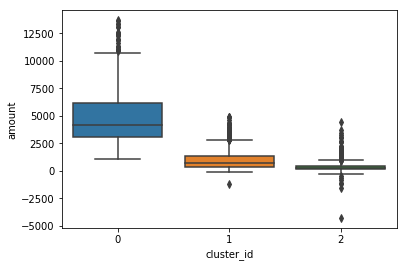

In [403]:
# plot
sns.boxplot(x='cluster_id', y='amount', data=grouped_df)

## Hierarchical Clustering

In [406]:
rfm_df_scaled.head()

,amount,frequency,recency
0,-0.723738,-0.752888,2.301611
1,1.731617,1.042467,-0.906466
2,0.300128,-0.463636,-0.183658
3,0.277517,-0.044720,-0.738141
4,-0.533235,-0.603275,2.143188


In [407]:
grouped_df.head()

,CustomerID,amount,frequency,recency,cluster_id
0,12346.0,0.00,2,325,2
1,12347.0,4310.00,182,1,0
2,12348.0,1797.24,31,74,1
3,12349.0,1757.55,73,18,1
4,12350.0,334.40,17,309,2


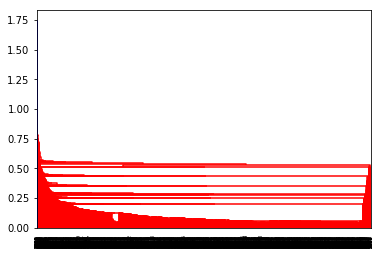

In [408]:
# single linkage
mergings = linkage(rfm_df_scaled, method="single", metric='euclidean')
dendrogram(mergings)
plt.show()

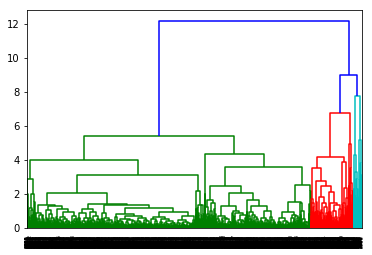

In [409]:
# complete linkage
mergings = linkage(rfm_df_scaled, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

In [415]:
# 3 clusters
cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )
cluster_labels

array([0, 1, 0, ..., 0, 0, 0])

In [416]:
# assign cluster labels
grouped_df['cluster_labels'] = cluster_labels
grouped_df.head()

,CustomerID,amount,frequency,recency,cluster_id,cluster_labels
0,12346.0,0.00,2,325,2,0
1,12347.0,4310.00,182,1,0,1
2,12348.0,1797.24,31,74,1,0
3,12349.0,1757.55,73,18,1,0
4,12350.0,334.40,17,309,2,0


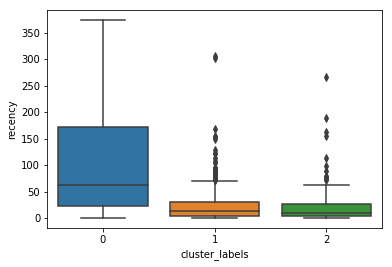

In [419]:
# plots
sns.boxplot(x='cluster_labels', y='recency', data=grouped_df)

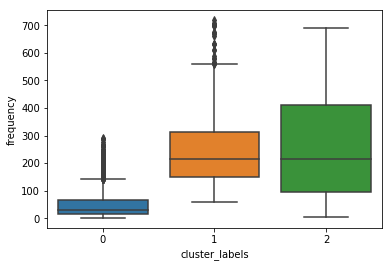

In [420]:
# plots
sns.boxplot(x='cluster_labels', y='frequency', data=grouped_df)

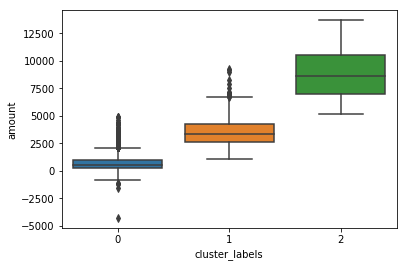

In [421]:
# plots
sns.boxplot(x='cluster_labels', y='amount', data=grouped_df)